# Данный файл предназначен для проверки работы класса ConsoleOnFuselage со статичной несущей поверхностью
# Графики в этом файле показывают отличие АДХ несущей поверхности установленной на фюзеляж от АДХ изолированной несущей поверхности

In [16]:
import os
import sys
AeroBDSM_OOP_dir = os.path.abspath(os.path.join('../../..'))
if AeroBDSM_OOP_dir not in sys.path:
    sys.path.append(AeroBDSM_OOP_dir)

from isolated_plane import *
from __ConsoleOnFuselage import *
from libs.Atmosphere import atmo
from math import *
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, read_excel

%config InlineBackend.figure_format = 'svg'

In [17]:
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

import warnings
warnings.filterwarnings("ignore")

In [18]:
# Неповоротная НП

# Параметры крыла
l_kr = 0.248            # размах крыла [м]
l_c = 0.124             # длина одной консоли [м]
b_b = 0.340             # бортовая хорда [м]
b_1 = 0.200             # концевая хорда [м]
chi_0 = radians(48.47)  # угол стреловидности по передней кромке [рад]
chi_1 = radians(0)      # угол стреловидности по задней кромке [рад]

x_b = 3.85              # расстояние от носа фюзеляжа до начала бортовой хорды консоли, м

# Параметры руля
#S_r = 0.0669            # площадь рулей
#lambd_r = 0.9185        # удлинение рулей
#xx_r = 0.5              # относительная координата оси вращения рулей

# Параметры профиля крыла
cc_b = 0.048            # относительная толщина профиля бортовой хорды [-]
cc_1 = 0.078            # относительная толщина профиля концевой хорды [-]
cc = (cc_b + cc_1) / 2  # средняя относительная толщина профиля [-]
xx_c = 0.5              # относительная координата положения максимальной толщины [-]
hb = 1e-5               # относительная высота бугорков профиля [-]
rr_0 = 0                # относительный радиус скругления передней кромки [-]
aa = 0.5                # отношение геометрического параметра профиля `a` в долях рассматриваемой хорды [-]

xx_0 = 0                # относительная координата центра вращения в долях САХ (от носка САХ) относительно которой считаются моменты
xx_t = None             # относительная координата перехода пограничного слоя из ламинарного в турбулентный в долях рассматриваемой хорды
T_s = None              # средняя температура поверхности крыла, К

H = 0                   # высота полёта
#delta = -10 / 57.3      # угол поворота рулей
omega_z = 0             # угловая скорость

In [19]:
# Расчет геометрических параметров

S_kr = (b_b + b_1) / 2 * l_kr
lambda_kr = l_kr ** 2 / S_kr
zeta_kr = b_1 / b_b
chi_05 = atan(tan(chi_0) - 2 / lambda_kr * (1 / zeta_kr - 1) / (1 / zeta_kr + 1))

In [20]:
Airfoil = HexProfile(b_b, cc, xx_c, aa, rr_0, hb)
IP = IsolatedPlane(S_kr, lambda_kr, zeta_kr, chi_05, Airfoil)
PonF = ConsoleOnFuselage(IP, 0, x_b)
#RotConsoles = IsolatedPlane_RotatingConsoles(S_kr, lambda_kr, zeta_kr, chi_05, S_r, lambd_r, xx_r, Airfoil)

In [21]:
# Геометрические параметры фюзеляжа

D = 0.31
L_main = 4.2
L_nos = 0.37
L_cor = 0.115   # длина кормы уменьшена до 0,1 из-за того, что крылья заходят на корму
D_dn = 0.27
r_sph = 0.0775    # 0.5 * D / 2
D_a = 0.9 * D_dn
h_s = 0e-5              # относительная высота бугорков поверхности фюзеляжа

xx_0 = 0.529            # относительная координата центра вращения в долях длины фюзеляжа (от носа) относительно которой считаются моменты
x_t = None              # относительная координата перехода пограничного слоя из ламинарного в турбулентный в долях длины фюзеляжа
T_s = None              # средняя температура поверхности фюзеляжа, К
is_active = False       # активный или пассивный (режим работы сопла на донном срезе)

S_m = pi * D**2 / 4
lambda_nos = L_nos / D
lambda_cor = L_cor / D
lambda_cil = (L_main - L_cor - L_nos) / D
eta_cor = D_dn / D
x_0 = xx_0 * L_main

In [22]:
nc = NosCil_SphOgi(
    lambd_nos=lambda_nos,
    lambd_cil=lambda_cil,
    D=D,
    r_sph=r_sph,    
    )
nc1 = NosCil_Ell(
    lambd_nos=lambda_nos,
    lambd_cil=lambda_cil,
    D=D    
)
cor = Cor_Con(
    D=D,
    eta_cor=eta_cor,
    lambd_cor=lambda_cor,
    D_a=D_a)
cor1 = Cor_Non(D = D, D_a = D_a)
fuselag = Fuselage(
    nosCil=nc1,
    cor=cor,
    h_s = h_s)

In [23]:
M06 = 0.6
M11 = 1.1
M15 = 1.5
M2 = 2

alpha_wing = np.linspace(-20, 20, 201)

In [24]:
cy_M06_IsP = []
cy_M11_IsP = []
cy_M15_IsP = []
cy_M2_IsP = []

cx_M06_IsP = []
cx_M11_IsP = []
cx_M15_IsP = []
cx_M2_IsP = []

xd_M06_IsP = []
xd_M11_IsP = []
xd_M15_IsP = []
xd_M2_IsP = []

zdc_M06_IsP = []
zdc_M11_IsP = []
zdc_M15_IsP = []
zdc_M2_IsP = []


for alf in alpha_wing:
    c_y = IP.c_y(M06, np.deg2rad(alf))    
    c_x = IP.c_x(M06, np.deg2rad(alf), H, xx_t, T_s)    
    xd = IP.x_d(M06, np.deg2rad(alf)) + x_b
    z_dc = IP.z_dc(M06, np.deg2rad(alf)) + fuselag.D/2
    cy_M06_IsP.append(c_y)    
    cx_M06_IsP.append(c_x)    
    xd_M06_IsP.append(xd)
    zdc_M06_IsP.append(z_dc)
    
for alf in alpha_wing:
    c_y = IP.c_y(M11, np.deg2rad(alf))    
    c_x = IP.c_x(M11, np.deg2rad(alf), H, xx_t, T_s)    
    xd = IP.x_d(M11, np.deg2rad(alf)) + x_b
    z_dc = IP.z_dc(M11, np.deg2rad(alf)) + fuselag.D/2
    cy_M11_IsP.append(c_y)    
    cx_M11_IsP.append(c_x)    
    xd_M11_IsP.append(xd) 
    zdc_M11_IsP.append(z_dc)

for alf in alpha_wing:
    c_y = IP.c_y(M15, np.deg2rad(alf))    
    c_x = IP.c_x(M15, np.deg2rad(alf), H, xx_t, T_s)    
    xd = IP.x_d(M15, np.deg2rad(alf)) + x_b
    z_dc = IP.z_dc(M15, np.deg2rad(alf)) + fuselag.D/2
    cy_M15_IsP.append(c_y)    
    cx_M15_IsP.append(c_x)    
    xd_M15_IsP.append(xd)
    zdc_M15_IsP.append(z_dc)

for alf in alpha_wing:
    c_y = IP.c_y(M2, np.deg2rad(alf))    
    c_x = IP.c_x(M2, np.deg2rad(alf), H, xx_t, T_s)    
    xd = IP.x_d(M2, np.deg2rad(alf)) + x_b
    z_dc = IP.z_dc(M2, np.deg2rad(alf)) + fuselag.D/2
    cy_M2_IsP.append(c_y)    
    cx_M2_IsP.append(c_x)    
    xd_M2_IsP.append(xd)
    zdc_M2_IsP.append(z_dc)

In [25]:
cy_M06_PonF = []
cy_M11_PonF = []
cy_M15_PonF = []
cy_M2_PonF = []

cx_M06_PonF = []
cx_M11_PonF = []
cx_M15_PonF = []
cx_M2_PonF = []

xd_M06_PonF = []
xd_M11_PonF = []
xd_M15_PonF = []
xd_M2_PonF = []

zdc_M06_PonF = []
zdc_M11_PonF = []
zdc_M15_PonF = []
zdc_M2_PonF = []

for alf in alpha_wing:
    c_y = PonF.c_y(fuselag, M06, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)    
    c_x = PonF.c_x(fuselag, M06, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)    
    xd = PonF.x_d(fuselag, M06, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)
    z_dc = PonF.z_d(fuselag, M06, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)
    cy_M06_PonF.append(c_y)    
    cx_M06_PonF.append(c_x)    
    xd_M06_PonF.append(xd)
    zdc_M06_PonF.append(z_dc)
    
for alf in alpha_wing:
    c_y = PonF.c_y(fuselag, M11, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)    
    c_x = PonF.c_x(fuselag, M11, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)    
    xd = PonF.x_d(fuselag, M11, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)
    z_dc = PonF.z_d(fuselag, M11, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)
    cy_M11_PonF.append(c_y)    
    cx_M11_PonF.append(c_x)    
    xd_M11_PonF.append(xd)
    zdc_M11_PonF.append(z_dc)

for alf in alpha_wing:
    c_y = PonF.c_y(fuselag, M15, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)    
    c_x = PonF.c_x(fuselag, M15, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)    
    xd = PonF.x_d(fuselag, M15, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)
    z_dc = PonF.z_d(fuselag, M15, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)
    cy_M15_PonF.append(c_y)    
    cx_M15_PonF.append(c_x)    
    xd_M15_PonF.append(xd)
    zdc_M15_PonF.append(z_dc)

for alf in alpha_wing:
    c_y = PonF.c_y(fuselag, M2, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)    
    c_x = PonF.c_x(fuselag, M2, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)    
    xd = PonF.x_d(fuselag, M2, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)
    z_dc = PonF.z_d(fuselag, M2, np.deg2rad(alf), H = H, xx_t = xx_t, T_s = T_s)
    cy_M2_PonF.append(c_y)    
    cx_M2_PonF.append(c_x)    
    xd_M2_PonF.append(xd)
    zdc_M2_PonF.append(z_dc)

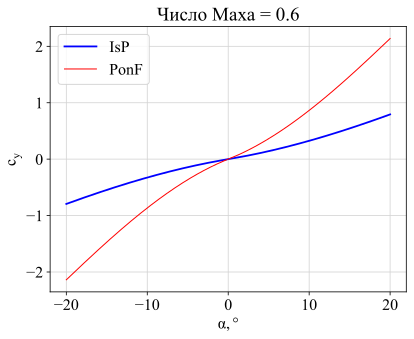

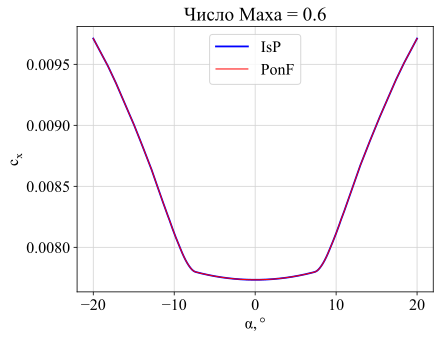

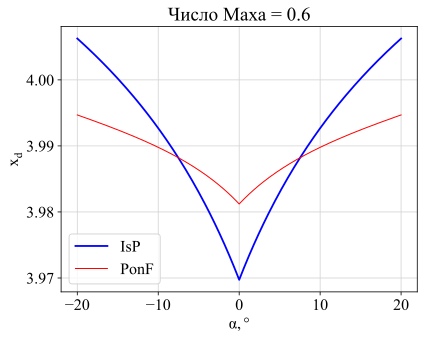

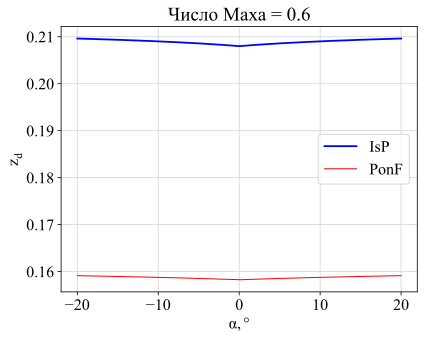

In [26]:
# Нормальная сила
plt.title('Число Маха = 0.6')
plt.plot(alpha_wing, cy_M06_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, cy_M06_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M06 c_y.jpeg', facecolor='white')
plt.show()

# Продольная сила
plt.title('Число Маха = 0.6')
plt.plot(alpha_wing, cx_M06_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, cx_M06_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M06 c_x.jpeg', facecolor='white')
plt.show()

# Центр давления
plt.title('Число Маха = 0.6')
plt.plot(alpha_wing, xd_M06_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, xd_M06_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M06 x_d.jpeg', facecolor='white')
plt.show()

# Центр давления
plt.title('Число Маха = 0.6')
plt.plot(alpha_wing, zdc_M06_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, zdc_M06_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$z_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M06 z_d.jpeg', facecolor='white')
plt.show()

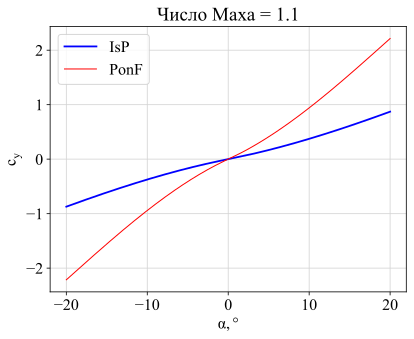

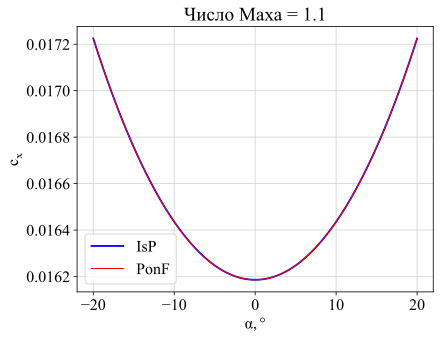

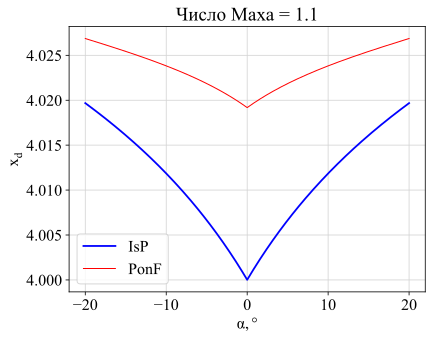

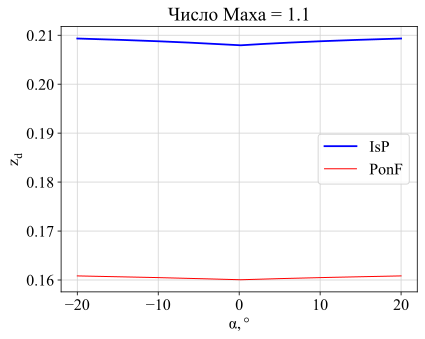

In [27]:
# Нормальная сила
plt.title('Число Маха = 1.1')
plt.plot(alpha_wing, cy_M11_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, cy_M11_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M11 c_y.jpeg', facecolor='white')
plt.show()

# Продольная сила
plt.title('Число Маха = 1.1')
plt.plot(alpha_wing, cx_M11_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, cx_M11_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M11 c_x.jpeg', facecolor='white')
plt.show()

# Центр давления
plt.title('Число Маха = 1.1')
plt.plot(alpha_wing, xd_M11_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, xd_M11_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M11 x_d.jpeg', facecolor='white')
plt.show()

# Центр давления
plt.title('Число Маха = 1.1')
plt.plot(alpha_wing, zdc_M11_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, zdc_M11_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$z_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M11 z_d.jpeg', facecolor='white')
plt.show()

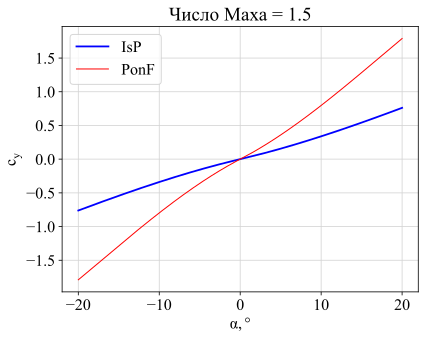

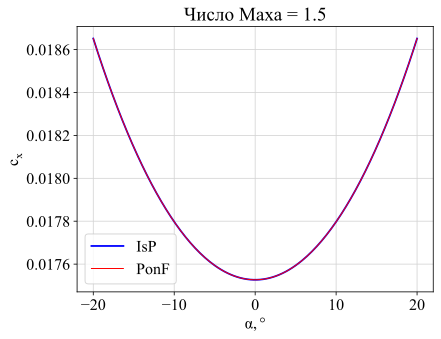

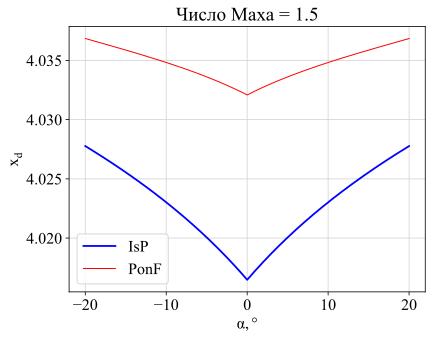

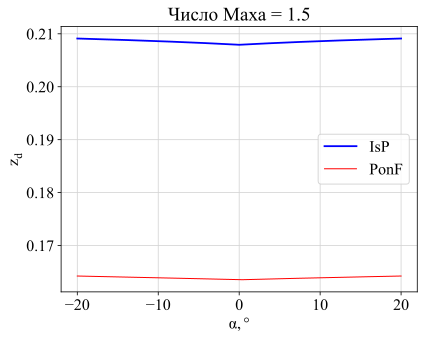

In [28]:
# Нормальная сила
plt.title('Число Маха = 1.5')
plt.plot(alpha_wing, cy_M15_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, cy_M15_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M15 c_y.jpeg', facecolor='white')
plt.show()

# Продольная сила
plt.title('Число Маха = 1.5')
plt.plot(alpha_wing, cx_M15_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, cx_M15_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M15 c_x.jpeg', facecolor='white')
plt.show()

# Центр давления
plt.title('Число Маха = 1.5')
plt.plot(alpha_wing, xd_M15_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, xd_M15_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M15 x_d.jpeg', facecolor='white')
plt.show()

# Центр давления
plt.title('Число Маха = 1.5')
plt.plot(alpha_wing, zdc_M15_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, zdc_M15_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$z_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M15 z_d.jpeg', facecolor='white')
plt.show()

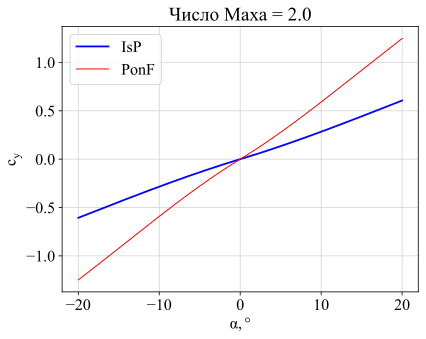

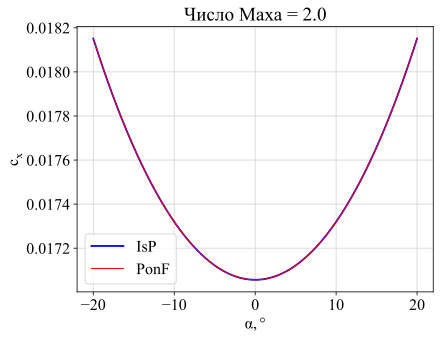

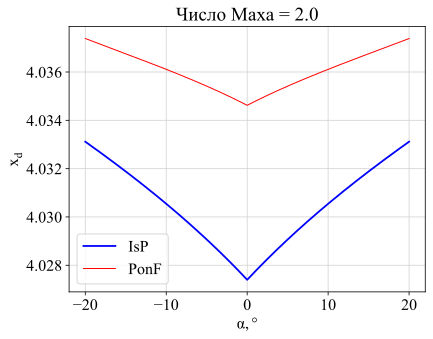

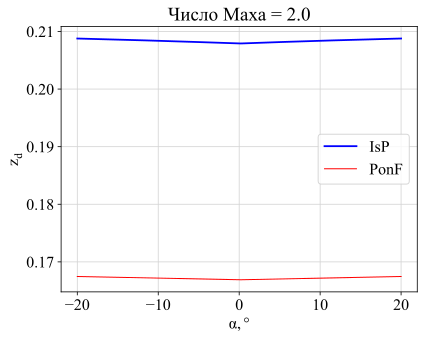

In [29]:
# Нормальная сила
plt.title('Число Маха = 2.0')
plt.plot(alpha_wing, cy_M2_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, cy_M2_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M2 c_y.jpeg', facecolor='white')
plt.show()

# Продольная сила
plt.title('Число Маха = 2.0')
plt.plot(alpha_wing, cx_M2_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, cx_M2_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M2 c_x.jpeg', facecolor='white')
plt.show()

# Центр давления
plt.title('Число Маха = 2.0')
plt.plot(alpha_wing, xd_M2_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, xd_M2_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M2 x_d.jpeg', facecolor='white')
plt.show()

# Центр давления
plt.title('Число Маха = 2.0')
plt.plot(alpha_wing, zdc_M2_IsP, color = 'blue', lw = 1.8, label = 'IsP')
plt.plot(alpha_wing, zdc_M2_PonF, color = 'red', lw = 1, label = 'PonF')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$z_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('plots_Static\M2 z_d.jpeg', facecolor='white')
plt.show()